TACOTRON

In [230]:
from __future__ import print_function
import mxnet as mx
import numpy as np
from mxnet import nd, autograd
from IPython.display import clear_output
ctx= mx.cpu()

In [263]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

def get_spectrograms(sound_file): 
    '''Extracts melspectrogram and log magnitude from given `sound_file`.
    Args:
      sound_file: A string. Full path of a sound file.

    Returns:
      Transposed S: A 2d array. A transposed melspectrogram with shape of (T, n_mels)
      Transposed magnitude: A 2d array.Has shape of (T, 1+hp.n_fft//2)
    '''
    frame_shift = 0.0125
    frame_length = 0.05
    
    # Loading sound file
    y, sr = librosa.load(sound_file) # or set sr to hp.sr.
    print("Sampling at "+str(sr))
    # stft. D: (1+n_fft//2, T)
    D = librosa.stft(y=y,
                     n_fft=2048, 
                     hop_length=int(sr*frame_shift), 
                     win_length=int(sr*frame_length)
                    ) 
    
    # magnitude spectrogram
    magnitude = np.abs(D) #(1+n_fft/2, T)
    
    log_magnitude=librosa.amplitude_to_db(magnitude,ref=np.max)
    
    # mel spectrogram
    S = librosa.feature.melspectrogram(S=log_magnitude, n_mels=80) #(n_mels, T)
    return S
    #return np.transpose(S.astype(np.float32)), np.transpose(magnitude.astype(np.float32)) # (T, n_mels), (T, 1+n_fft/2)


In [264]:
S=get_spectrograms('Goodbye-SoundBible.com-1660461090.wav')

Sampling at 22050


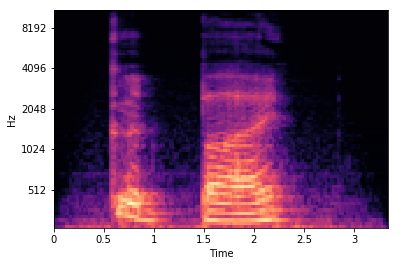

In [266]:
%matplotlib inline
librosa.display.specshow(S,y_axis='mel',x_axis='time')

In [82]:
num_hidden = 256

emb_size=256

In [83]:
def load_vocab():
    vocab = "abcdefghijklmnopqrstuvwxyz'" # E: Empty. ignore G
    char2idx = {char:idx for idx, char in enumerate(vocab)}
    idx2char = {idx:char for idx, char in enumerate(vocab)}
    return char2idx, idx2char  

In [84]:
"""
FC-256-ReLU → Dropout(0.5) → FC-128-ReLU → Dropout(0.5)
"""
def prenet_pass(data):
    fc1 = mx.symbol.FullyConnected(data=data, num_hidden=emb_size)
    act1 = mx.symbol.Activation(data=fc1, act_type='relu')
    drop1 = mx.symbol.Dropout(act1, p=0.5)
    
    fc2 = mx.symbol.FullyConnected(data=drop1, num_hidden=emb_size//2)
    act2 = mx.symbol.Activation(data=fc2, act_type='relu')
    prenet_output = mx.symbol.Dropout(act2, p=0.5)
    
    return prenet_output

In [85]:
# banco di filtri convolutivi. Vengono creati K filtri con kernel 1D di dimensione:k 
def conv1dBank(conv_input, K):
    conv=mx.sym.Convolution(data=conv_input, kernel=(1,1), num_filter=emb_size//2)
    (conv, mean, var) = mx.sym.BatchNorm(data=conv, output_mean_var=True)
    conv = mx.sym.Activation(data=conv, act_type='relu')
    for k in range(2, K+1):
        convi = mx.sym.Convolution(data=conv_input, kernel=(k,1), num_filter=emb_size//2)
        (convi, mean, var) = mx.sym.BatchNorm(data=convi, output_mean_var=True)
        convi = mx.sym.Activation(data=convi, act_type='relu')
        conv = mx.symbol.concat(conv,convi)
    return conv

In [86]:
# highway
def highway_layer(data):
    H= mx.symbol.Activation(data=mx.symbol.FullyConnected(data=data, num_hidden=emb_size//2), act_type="relu")
    T= mx.symbol.Activation(data=mx.symbol.FullyConnected(data=data, num_hidden=emb_size//2, bias=mx.sym.Variable('bias') ), act_type="sigmoid")
    return  H * T + data * (1.0 - T)


In [100]:
# CBHG
def CBHG(data,K,proj1_size,proj2_size):
    #se si usa infer_shape su convbank dando la dimensione dell'input, viene dedotta la shape appunto 
    bank = conv1dBank(data,K)
    poold_bank = mx.sym.Pooling(data=bank, pool_type='max', kernel=(2, 1), stride=(1,1))

    proj1 = mx.sym.Convolution(data=poold_bank, kernel=(3,1), num_filter=proj1_size)
    (proj1, proj1_mean, proj1_var) = mx.sym.BatchNorm(data=proj1, output_mean_var=True)
    proj1 = mx.sym.Activation(data=proj1, act_type='relu')#Is it ok to declare/use again the same variable?  

    proj2 = mx.sym.Convolution(proj1, kernel=(3,1), num_filter=proj2_size)
    (proj2, proj2_mean, proj2_var) = mx.sym.BatchNorm(data=proj2, output_mean_var=True)
    
    residual= proj2 + data

    for i in range(4):
        residual = highway_layer(residual)
    highway_pass = residual
   
    bidirectional_gru_cell = mx.rnn.BidirectionalCell(mx.rnn.GRUCell(num_hidden=emb_size//2),
                                                      mx.rnn.GRUCell(num_hidden=emb_size//2)
                                                     )
    outputs, states = bidirectional_gru_cell.unroll(1, inputs=highway_pass, merge_outputs=True)
    return outputs

In [108]:
# encoder
def encoder(data):
    char2index, index2char = load_vocab()
    
    onehot = mx.sym.one_hot(data,len(char2index))
    embed_vector = mx.sym.Embedding(data=onehot, input_dim=100, output_dim=emb_size)
    prenet_output = prenet_pass(embed_vector)
    return CBHG(prenet_output,16, emb_size//2, emb_size//2)

In [202]:
text = mx.sym.Variable('text')

encoded = encoder(text)
graph=mx.viz.plot_network(
    encoded,
    save_format='pdf',
    title='encoder')
graph.render()

'encoder.gv.pdf'

In [209]:
# decoder
def decoder(data,context,reduction_factor):
    prenet_output = prenet_pass(data)
        
    stack = mx.rnn.SequentialRNNCell()
    stack.add(mx.rnn.GRUCell(num_hidden=emb_size,prefix='decoder_layer1_'))
    stack.add(mx.rnn.GRUCell(num_hidden=emb_size,prefix='decoder_layer2_'))
    
    residual_gru_stack = mx.rnn.ResidualCell(stack)
    
    gru_outputs,states = residual_gru_stack.unroll(length=1,
                                               inputs=prenet_output,
                                               begin_state=context,
                                               merge_outputs=True)

    predicted_frames = mx.symbol.Activation(
        data=mx.symbol.FullyConnected(data=gru_outputs, num_hidden=reduction_factor),
        act_type="relu"
    )
    
    return predicted_frames, states

In [210]:
spectrogram = mx.sym.Variable('spectrogram')
reduction_factor=2
spectrograms_count=1 #dummy value
decoder_state=[encoded,encoded]
predicted_frames=spectrogram
full_frame=mx.sym.Variable('go')

for i in range(spectrograms_count):
    predicted_frames,decoder_state = decoder(predicted_frames,decoder_state,reduction_factor)
    full_frame=mx.sym.concat(full_frame,predicted_frames)

spectral_magnitude=CBHG(full_frame,8, emb_size, 80)

graph=mx.viz.plot_network(
    full_frame,
    save_format='pdf',
    title='decoder')
graph.render()

'decoder.gv.pdf'

<h2> Attention model part </h2>

Need to figure out what is going on here.

"memory" part = data (embeddings, apples, whatever)-> prenet -> encoder-CBHG   

keithito implementation: 

      # Attention
      attention_cell = AttentionWrapper(
        DecoderPrenetWrapper(GRUCell(256), is_training),
        BahdanauAttention(256, encoder_outputs),
        alignment_history=True,
        output_attention=False)                                                  # [N, T_in, 256]
first arg: a RNN cell 
second: attention mechanism

both AttentionWrapper and BahdanauAttention comes from tf.contrib.seq2seq package
    
The DecoderPrenetWrapper:
<div style="background-color:gray">
<code style="background-color:gray">
class DecoderPrenetWrapper(RNNCell):
  '''Runs RNN inputs through a prenet before sending them to the cell.'''
  
  bla bla bla
  
  <b>def call(self, inputs, state):
    prenet_out = prenet(inputs, self._is_training, scope='decoder_prenet')
    return self._cell(prenet_out, state)
  </b>  
  bla bla bla
</code></div>

So it just send data to the prenet. Data comes from encoder_cbhg.
    The AttentionWrapper, wraps a attention mechanism (Bahdanau) that look at a memory to query (the encoder output) and a net (GRU 256) that is the attention net
